In [1]:
from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut
from IPython.utils import io
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Activation

In [2]:
features = pd.read_csv('Dataset/gastrointestinal_colonoscopy_lesions_dataset.csv')
features = features.T
class_label = pd.Series(features.index)
features.index = range(features.shape[0])
classes = np.zeros((features.shape[0], 3))
for i in range(classes.shape[0]):
    if 'adenoma' in class_label[i]:
        classes[i,0] = 1.0
        class_label[i] = 0
    elif 'serrated' in class_label[i]:
        classes[i,2] = 1.0
        class_label[i] = 2
    else:
        classes[i,1] = 1.0
        class_label[i] = 1
classes = {'adenoma': classes[:,0], 'hyperplasic': classes[:,1], 'serrated': classes[:,2]}
classes = pd.DataFrame(classes)
class_label = class_label.astype('int')

In [3]:
for col in features.columns:
    if features[col].abs().max()==0:
        continue
    features[col] = (features[col] - features[col].mean())/features[col].abs().max()
features

,0,1,2,3,4,5,6,7,8,9,...,690,691,692,693,694,695,696,697,698,699
0,0.250000,-0.25,0.048325,-0.005553,-0.056058,-0.084224,-0.037834,-0.031987,-0.101462,-0.050684,...,0.397177,0.392793,0.388256,0.383761,0.384351,0.383117,0.379185,0.365162,0.365579,0.375950
1,0.250000,0.25,-0.001203,0.367137,-0.084265,-0.100569,0.018451,0.046227,-0.101911,-0.038210,...,0.397177,0.392793,0.388256,0.383761,0.384351,0.383117,0.379185,0.365162,0.365579,0.375950
2,0.250000,0.25,-0.233810,0.046065,0.024136,0.032700,-0.031101,-0.036372,-0.169688,-0.154002,...,0.060715,0.057743,0.055493,0.056890,0.052044,0.053244,0.052057,0.045743,0.046962,0.047065
3,0.250000,-0.25,-0.182565,0.057049,-0.031463,-0.025114,-0.050518,-0.035422,-0.067798,-0.052955,...,0.060715,0.057743,0.055493,0.056890,0.052044,0.053244,0.052057,0.045743,0.046962,0.047065
4,0.250000,0.25,-0.107936,-0.094438,0.092679,0.038768,0.186656,0.125008,0.095410,0.078630,...,-0.054256,-0.053808,-0.052869,-0.052718,-0.051934,-0.051097,-0.050394,-0.050345,-0.049870,-0.049726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,-0.083333,0.25,0.040649,-0.066683,-0.185786,-0.250955,-0.163660,-0.173238,-0.232896,-0.223542,...,-0.054095,-0.053643,-0.052701,-0.052581,-0.051796,-0.050957,-0.050288,-0.050236,-0.049758,-0.049611
148,-0.083333,0.25,-0.153445,0.092191,-0.010435,-0.057762,-0.097339,-0.111005,-0.120050,0.000883,...,-0.043740,-0.044039,-0.043146,-0.043641,-0.042803,-0.042638,-0.042785,-0.042676,-0.042227,-0.042307
149,-0.083333,-0.25,0.144594,0.231284,-0.043448,-0.041229,-0.173962,-0.202734,-0.153664,-0.000519,...,-0.043740,-0.044039,-0.043146,-0.043641,-0.042803,-0.042638,-0.042785,-0.042676,-0.042227,-0.042307
150,-0.083333,-0.25,-0.169496,-0.098815,-0.207792,-0.250433,-0.221289,-0.226000,0.073333,0.138157,...,-0.053643,-0.053247,-0.052332,-0.052204,-0.051450,-0.050608,-0.049938,-0.049907,-0.049461,-0.049344


In [4]:
model = Sequential([
    
    InputLayer(input_shape=(features.shape[1])),
    
    Dense(7, activation='sigmoid'),
    
    Dense(5, activation='sigmoid'),
    
    Dense(3, activation='sigmoid')
])

model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
             )
model.summary()
model.save_weights('model_weights/initial_weights_colonoscopy')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 4907      
                                                                 
 dense_1 (Dense)             (None, 5)                 40        
                                                                 
 dense_2 (Dense)             (None, 3)                 18        
                                                                 
Total params: 4,965
Trainable params: 4,965
Non-trainable params: 0
_________________________________________________________________


In [5]:
acc = 0
j = 0
for train_index, test_index in LeaveOneOut().split(features):
    x_train, x_test = features.iloc[train_index,:], features.iloc[test_index,:]
    y_train, y_test = classes.iloc[train_index,:], classes.iloc[test_index,:]
    model.load_weights('model_weights/initial_weights_colonoscopy')
    with io.capture_output() as captured:
        model.fit(x_train, y_train, epochs=500)
    acc += model.evaluate(x_test, y_test)[1]
    j+=1

1/1 [==============================] - 0s 16ms/step - loss: 0.1652 - accuracy: 1.0000


1/1 [==============================] - 0s 16ms/step - loss: 0.6006 - accuracy: 0.0000e+00


In [6]:
print('Accuracy: ', acc/j)

Accuracy:  0.868421052631579


In [7]:
model.fit(features, classes, epochs=500)

Epoch 1/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0815 - accuracy: 0.9934
Epoch 2/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0810 - accuracy: 0.9934
Epoch 3/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0805 - accuracy: 0.9934
Epoch 4/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0800 - accuracy: 0.9934
Epoch 5/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0796 - accuracy: 0.9934
Epoch 6/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0791 - accuracy: 1.0000
Epoch 7/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0786 - accuracy: 1.0000
Epoch 8/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0783 - accuracy: 1.0000
Epoch 9/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0779 - accuracy: 1.0000
Epoch 10/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0775 - accuracy: 1.0000
Epoch 11/500
5/5 [===========

5/5 [==============================] - 0s 2ms/step - loss: 0.0566 - accuracy: 1.0000
Epoch 85/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0564 - accuracy: 1.0000
Epoch 86/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0562 - accuracy: 1.0000
Epoch 87/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0560 - accuracy: 1.0000
Epoch 88/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0557 - accuracy: 1.0000
Epoch 89/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0555 - accuracy: 1.0000
Epoch 90/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0553 - accuracy: 1.0000
Epoch 91/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0551 - accuracy: 1.0000
Epoch 92/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0548 - accuracy: 1.0000
Epoch 93/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0546 - accuracy: 1.0000
Epoch 94/500
5/5 [===============

5/5 [==============================] - 0s 2ms/step - loss: 0.0413 - accuracy: 1.0000
Epoch 168/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0411 - accuracy: 1.0000
Epoch 169/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0410 - accuracy: 1.0000
Epoch 170/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0408 - accuracy: 1.0000
Epoch 171/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0407 - accuracy: 1.0000
Epoch 172/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0405 - accuracy: 1.0000
Epoch 173/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0404 - accuracy: 1.0000
Epoch 174/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0402 - accuracy: 1.0000
Epoch 175/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0401 - accuracy: 1.0000
Epoch 176/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0399 - accuracy: 1.0000
Epoch 177/500
5/5 [=====

5/5 [==============================] - 0s 2ms/step - loss: 0.0309 - accuracy: 1.0000
Epoch 250/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0308 - accuracy: 1.0000
Epoch 251/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0307 - accuracy: 1.0000
Epoch 252/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0306 - accuracy: 1.0000
Epoch 253/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0305 - accuracy: 1.0000
Epoch 254/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0304 - accuracy: 1.0000
Epoch 255/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0303 - accuracy: 1.0000
Epoch 256/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0302 - accuracy: 1.0000
Epoch 257/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0301 - accuracy: 1.0000
Epoch 258/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0300 - accuracy: 1.0000
Epoch 259/500
5/5 [=====

5/5 [==============================] - 0s 2ms/step - loss: 0.0236 - accuracy: 1.0000
Epoch 332/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0235 - accuracy: 1.0000
Epoch 333/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0234 - accuracy: 1.0000
Epoch 334/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0233 - accuracy: 1.0000
Epoch 335/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0233 - accuracy: 1.0000
Epoch 336/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0232 - accuracy: 1.0000
Epoch 337/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0231 - accuracy: 1.0000
Epoch 338/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0230 - accuracy: 1.0000
Epoch 339/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0230 - accuracy: 1.0000
Epoch 340/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0229 - accuracy: 1.0000
Epoch 341/500
5/5 [=====

5/5 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 1.0000
Epoch 414/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0181 - accuracy: 1.0000
Epoch 415/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0181 - accuracy: 1.0000
Epoch 416/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0180 - accuracy: 1.0000
Epoch 417/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0179 - accuracy: 1.0000
Epoch 418/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0179 - accuracy: 1.0000
Epoch 419/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0178 - accuracy: 1.0000
Epoch 420/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0178 - accuracy: 1.0000
Epoch 421/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 1.0000
Epoch 422/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 1.0000
Epoch 423/500
5/5 [=====

5/5 [==============================] - 0s 2ms/step - loss: 0.0142 - accuracy: 1.0000
Epoch 496/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0142 - accuracy: 1.0000
Epoch 497/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 1.0000
Epoch 498/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 1.0000
Epoch 499/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 1.0000
Epoch 500/500
5/5 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 1.0000


In [8]:
grad_sum = 0
for col_name in tqdm(features.columns):
    pointFrame = features.loc[:, features.columns != col_name]
    for i in features[col_name]:
        pointFrame[col_name] = i*np.ones(len(features.index))
        points = tf.Variable(pointFrame, dtype='float')
        with tf.GradientTape() as tape:
            pred = model(points, training=False)
        grads = tape.gradient(pred, points)
        grad_sum += np.abs(grads.numpy())
saliency_order = np.argsort(-np.sum(np.abs(grad_sum), 0))

100%|██████████| 700/700 [07:05<00:00,  1.65it/s]


In [9]:
print('The features arranged in order of saliency are: \n')
features[saliency_order]

The features arranged in order of saliency are: 



,0,547,464,146,571,545,549,459,546,466,...,249,257,353,404,385,260,214,182,359,416
0,0.250000,0.019453,0.156682,0.014037,-0.000891,0.020956,0.013944,-0.031571,0.017661,0.037353,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.250000,0.019453,-0.071990,0.009191,-0.000891,0.020956,0.013944,-0.031571,0.017661,0.278855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.250000,0.012418,-0.131291,0.008758,0.008760,0.007180,0.016346,-0.031571,-0.007271,0.171833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.250000,0.012418,-0.140440,0.066090,0.008760,0.007180,0.016346,-0.031571,-0.007271,-0.195110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.250000,0.018683,-0.029781,-0.104275,0.011717,0.012956,0.017094,-0.031571,0.021297,0.284429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,-0.083333,0.006751,0.063551,-0.029268,-0.016223,0.018410,-0.003144,-0.031571,0.006035,0.280373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,-0.083333,0.009858,-0.040653,-0.007182,0.012807,0.009247,0.007949,0.586617,0.009186,0.193040,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149,-0.083333,0.009858,-0.026035,0.030283,0.012807,0.009247,0.007949,-0.031571,0.009186,-0.075700,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150,-0.083333,-0.044736,-0.140440,-0.007820,0.009538,-0.043478,-0.039516,-0.031571,-0.050214,-0.195110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[]

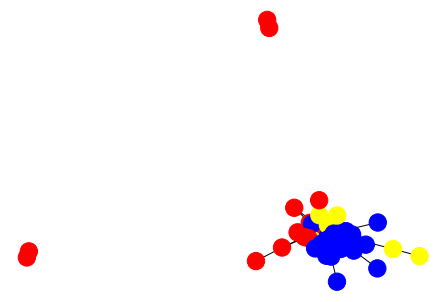

In [10]:
num_features = 100
salient_features = features.iloc[:,saliency_order[0:num_features]]
A = np.zeros((features.shape[0], features.shape[0]))
for i in features.index:
    for j in range(i):
        A[i,j] = np.linalg.norm(salient_features.iloc[i,:] - salient_features.iloc[j,:])
A = A + np.transpose(A)
p = 1.3
A = (A < p)
A = A - np.eye(A.shape[0])
rows, cols = np.where(A==1)
edges = zip(rows.tolist(), cols.tolist())
G = nx.Graph()
G.add_edges_from(edges, node_size=1)
color_map = np.array([])
for node in G:
    if (class_label[node]==0):
        color_map = np.append(color_map, 'red')
    elif (class_label[node]==1):
        color_map = np.append(color_map, 'blue')
    else:
        color_map = np.append(color_map, 'yellow')
nx.draw(G, node_color=color_map)
plt.plot()

In [11]:
nx.is_connected(G) # tells whether or not the graph is connected
# nx.clustering(G) # gives the clustering value of each vertex

False

In [12]:
nx.number_connected_components(G) # number of different connected components

3

In [13]:
nx.density(G) # this tells how close the graph is to being fully connected

0.38791946308724834

In [14]:
nx.average_clustering(G) # clustering value for the whole graph

0.7081425611264923

In [15]:
nx.transitivity(G) # 3* number of triangles in G/ number of connected triads in G

0.7534515406095325

[]

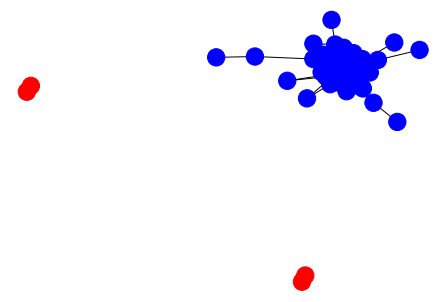

In [16]:
giant_component = G.subgraph(max(nx.connected_components(G), key=len))
color_map_GC = np.array([])
for node in G:
    if node in giant_component:
        color_map_GC = np.append(color_map_GC, 'blue')
    else:
        color_map_GC = np.append(color_map_GC, 'red')
nx.draw(G, node_color=color_map_GC)
plt.plot()

In [17]:
nx.eccentricity(giant_component) # largest possible shortest path distance between a vertex and all other vertices

{0: 4,
 1: 4,
 3: 4,
 5: 4,
 6: 4,
 7: 4,
 8: 4,
 9: 4,
 10: 4,
 11: 4,
 13: 4,
 14: 4,
 15: 4,
 16: 4,
 17: 4,
 18: 5,
 20: 4,
 21: 4,
 22: 4,
 24: 4,
 26: 4,
 27: 4,
 28: 4,
 30: 4,
 31: 4,
 32: 4,
 33: 4,
 34: 4,
 35: 4,
 36: 5,
 38: 4,
 42: 4,
 43: 4,
 46: 4,
 47: 4,
 49: 5,
 50: 4,
 54: 4,
 56: 4,
 57: 4,
 58: 4,
 59: 4,
 60: 5,
 62: 4,
 64: 4,
 66: 4,
 72: 4,
 76: 4,
 78: 4,
 124: 4,
 127: 4,
 128: 3,
 132: 4,
 136: 4,
 137: 4,
 138: 4,
 140: 4,
 141: 4,
 142: 4,
 144: 4,
 146: 4,
 149: 3,
 150: 4,
 2: 4,
 4: 4,
 12: 4,
 23: 4,
 25: 4,
 29: 4,
 37: 4,
 39: 4,
 41: 4,
 51: 4,
 53: 4,
 55: 4,
 61: 4,
 63: 4,
 65: 4,
 67: 4,
 73: 4,
 75: 4,
 77: 4,
 89: 4,
 99: 4,
 102: 4,
 116: 4,
 123: 4,
 125: 4,
 126: 4,
 129: 4,
 133: 4,
 139: 4,
 143: 4,
 145: 4,
 147: 4,
 148: 4,
 151: 4,
 52: 4,
 69: 4,
 96: 4,
 97: 4,
 113: 4,
 40: 4,
 90: 5,
 122: 4,
 108: 4,
 131: 4,
 68: 5,
 74: 5,
 80: 4,
 100: 3,
 19: 5,
 81: 4,
 87: 4,
 101: 4,
 85: 4,
 91: 4,
 95: 4,
 121: 4,
 88: 4,
 114: 4,
 82: 4,

In [18]:
nx.diameter(giant_component) # maximum shortest distance between a pair of vertices in G, it is the largest possible eccentricity value of a vertex

6

In [19]:
nx.radius(giant_component) #  minimum eccentricity value of a vertex

3

In [20]:
# below gives us the different centrality measures for the vertices of the graphs
nx.degree_centrality(G) 

{0: 0.4161073825503356,
 1: 0.5234899328859061,
 3: 0.5369127516778524,
 5: 0.4563758389261745,
 6: 0.5704697986577181,
 7: 0.2953020134228188,
 8: 0.6442953020134228,
 9: 0.3825503355704698,
 10: 0.697986577181208,
 11: 0.6174496644295302,
 13: 0.5570469798657718,
 14: 0.6644295302013423,
 15: 0.6040268456375839,
 16: 0.5503355704697986,
 17: 0.3624161073825503,
 18: 0.2080536912751678,
 20: 0.5637583892617449,
 21: 0.6577181208053691,
 22: 0.6577181208053691,
 24: 0.6241610738255033,
 26: 0.5302013422818792,
 27: 0.5973154362416108,
 28: 0.5436241610738255,
 30: 0.42953020134228187,
 31: 0.5570469798657718,
 32: 0.5704697986577181,
 33: 0.5302013422818792,
 34: 0.5973154362416108,
 35: 0.6308724832214765,
 36: 0.28187919463087246,
 38: 0.5906040268456376,
 42: 0.35570469798657717,
 43: 0.6912751677852349,
 46: 0.348993288590604,
 47: 0.6241610738255033,
 49: 0.020134228187919462,
 50: 0.5906040268456376,
 54: 0.6577181208053691,
 56: 0.5704697986577181,
 57: 0.7114093959731543,
 58: 

In [21]:
max(nx.degree_centrality(G))

151

In [22]:
nx.eigenvector_centrality(G)

{0: 0.07723818634541459,
 1: 0.09986711432002111,
 3: 0.1017055103823074,
 5: 0.08168307351286896,
 6: 0.10883963061137839,
 7: 0.058003821081016614,
 8: 0.11747484877223915,
 9: 0.07102297749350296,
 10: 0.12226641040199668,
 11: 0.11266389666245914,
 13: 0.10441418433291422,
 14: 0.11999210393063231,
 15: 0.1109849524316201,
 16: 0.1058070989167064,
 17: 0.06834788565420588,
 18: 0.03621810660546493,
 20: 0.10558642843090094,
 21: 0.1193474362031259,
 22: 0.118504573459797,
 24: 0.11525728540389939,
 26: 0.09865517261543875,
 27: 0.10985298039501518,
 28: 0.10136776786072413,
 30: 0.07976398947831366,
 31: 0.10510753902295028,
 32: 0.10721852640814587,
 33: 0.10061528995878627,
 34: 0.10882881373670086,
 35: 0.11604915863510672,
 36: 0.04915386856792384,
 38: 0.11058811830927413,
 42: 0.0662477693179741,
 43: 0.12183106815535338,
 46: 0.06965894966810064,
 47: 0.11490266465058062,
 49: 0.002355435010610335,
 50: 0.11172853367314348,
 54: 0.11991054426987308,
 56: 0.10263298732190534,

In [24]:
max(nx.eigenvector_centrality(G))

151

In [25]:
nx.closeness_centrality(G)

{0: 0.5953897997904455,
 1: 0.6413971934106162,
 3: 0.6413971934106162,
 5: 0.6082214765100671,
 6: 0.6593802922912878,
 7: 0.5324806888691909,
 8: 0.6985513987640375,
 9: 0.5806888170795702,
 10: 0.727357642012039,
 11: 0.6816781765716694,
 13: 0.6502644357158321,
 14: 0.7090823243735457,
 15: 0.6719399169063599,
 16: 0.6532749192145165,
 17: 0.5689813812513531,
 18: 0.4899561894108874,
 20: 0.6532749192145165,
 21: 0.7055369127516778,
 22: 0.7055369127516778,
 24: 0.6883286953674905,
 26: 0.6384949436666768,
 27: 0.6751549404322276,
 28: 0.6443259477184273,
 30: 0.5953897997904455,
 31: 0.6563134072108632,
 32: 0.6624759744147211,
 33: 0.6443259477184273,
 34: 0.6751549404322276,
 35: 0.6917028556388999,
 36: 0.5226199353716133,
 38: 0.6687553675371354,
 42: 0.5712849495965003,
 43: 0.7236276028222337,
 46: 0.5621808069734485,
 47: 0.6883286953674905,
 49: 0.40548098434004476,
 50: 0.6687553675371354,
 54: 0.7055369127516778,
 56: 0.6656008610864885,
 57: 0.7349342841163312,
 58: 0.7

In [28]:
max(nx.closeness_centrality(G))

151

In [29]:
nx.betweenness_centrality(G)

{0: 0.01037935915179116,
 1: 0.0016091929015440048,
 3: 0.0018520946988251812,
 5: 0.003572847878940805,
 6: 0.0018413930676144047,
 7: 0.00567711453439371,
 8: 0.0040221834613796345,
 9: 0.0012970836417924634,
 10: 0.007310746107880942,
 11: 0.005231234949753208,
 13: 0.0023836675173915752,
 14: 0.004378131883988671,
 15: 0.003625550419719558,
 16: 0.0014397903056928094,
 17: 0.0008110743731963044,
 18: 0.00025071100848277956,
 20: 0.003078025942384054,
 21: 0.004267682134281057,
 22: 0.006213825652991875,
 24: 0.0034103396722924965,
 26: 0.002918990404524792,
 27: 0.003704064296407462,
 28: 0.0025047674606430543,
 30: 0.0017907530732116249,
 31: 0.002955816896574165,
 32: 0.0022721073715556536,
 33: 0.0018206805115335363,
 34: 0.02210492669220816,
 35: 0.003899490824939534,
 36: 0.0012481221556012304,
 38: 0.0030875857548232294,
 42: 0.0017126533648128316,
 43: 0.007572446116479692,
 46: 0.0002775469732669213,
 47: 0.005069540158561021,
 49: 0.013060039905677489,
 50: 0.0021387122425

In [31]:
max(nx.betweenness_centrality(G))

151

In [32]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(salient_features)
predicted_label = kmeans.labels_
print('Number of Iterations: ', kmeans.n_iter_)

Number of Iterations:  10


In [33]:
print('Cluster Centers: ', kmeans.cluster_centers_)

Cluster Centers:  [[-4.16666667e-01 -1.12490608e-02  6.77980650e-02  1.05648660e-02
  -3.64523405e-03 -1.18386724e-02 -8.30185481e-03 -2.11062594e-02
  -1.00279710e-02  8.38850923e-03 -8.40249361e-03 -8.14373591e-03
  -7.35033779e-03 -3.48474946e-03 -1.92541212e-03 -1.66959100e-02
   8.64306479e-02 -2.32171334e-04 -3.89375997e-02 -9.89377512e-03
  -4.78131333e-03 -5.39271554e-03 -1.69750674e-03  2.34906218e-02
   1.05616485e-02 -5.73532690e-02 -2.74300937e-03 -1.03399780e-02
   8.59845589e-02  7.02793902e-02 -2.19670122e-02  7.79994721e-02
  -1.24277887e-02 -1.12954979e-01 -3.28154472e-02 -1.76429055e-03
  -3.87764755e-02 -1.44105546e-01  7.07704430e-02 -1.17681573e-02
  -1.12392753e-02  1.87411576e-02 -1.89196563e-03  4.49203978e-02
  -2.73938867e-02  2.10222412e-02 -1.01036413e-02 -1.37113437e-03
   4.52603377e-02 -3.12747258e-02  3.71309722e-02 -2.48084979e-02
   1.72930886e-02  4.49900306e-02  7.36356483e-03 -6.30517346e-02
  -7.58912273e-02 -2.06363534e-02  7.35923949e-02 -4.44141

In [34]:
print('Inertia: ', kmeans.inertia_) # SSE

Inertia:  135.0862500161339


In [40]:
compared_classes = np.array([])
for i in classes.iterrows():
    if i[1]['adenoma']==1:
        compared_classes = np.append(compared_classes, 2)
    elif i[1]['hyperplasic']==1:
        compared_classes = np.append(compared_classes, 0)
    else:
        compared_classes = np.append(compared_classes, 1)
print('KMeans accuracy for 3 classes: ', np.count_nonzero(compared_classes==predicted_label)/ len(predicted_label))

KMeans accuracy for 3 classes:  0.625


In [41]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(salient_features)
predicted_label = kmeans.labels_
print('Number of Iterations: ', kmeans.n_iter_)

Number of Iterations:  5


In [42]:
print('Cluster Centers: ', kmeans.cluster_centers_)

Cluster Centers:  [[-3.16666667e-01 -1.64343827e-02  5.50725818e-02  1.41013705e-02
  -5.05155019e-03 -1.62280447e-02 -1.44529404e-02 -2.98342938e-02
  -1.53839183e-02  4.25953920e-03 -3.86170184e-02 -8.14373591e-03
  -1.42764601e-02 -1.13541303e-02  3.34851961e-03 -7.56246863e-03
   7.01458389e-02  2.24311503e-03 -3.00878922e-02 -1.58679609e-02
  -1.52066541e-02  8.15512823e-03  3.12004364e-03  3.77982259e-02
  -3.67281909e-02 -5.05873077e-02 -5.58471499e-03 -2.19173105e-02
   9.45867158e-02  8.14247122e-02 -1.75401026e-02  6.41899414e-02
  -1.19632155e-02 -1.13939102e-01 -4.61272869e-02 -6.86666240e-03
  -2.79616572e-02 -1.24290489e-01  5.80147556e-02 -1.54352689e-02
  -1.59772484e-02  1.41217155e-02  1.18575198e-03  3.77400569e-02
  -2.49601399e-02  2.75926042e-02 -1.43358750e-02  4.48727789e-03
   3.78028715e-02 -2.89430892e-02  2.26614803e-02 -2.10109630e-02
   2.94406403e-02  3.80374332e-02  1.75203810e-02 -2.90474345e-02
  -6.91067117e-02 -1.66208272e-02  6.51595429e-02 -3.30704

In [43]:
print('Inertia: ', kmeans.inertia_) # SSE

Inertia:  147.65095104199597


In [44]:
compared_classes = np.array([])
for i in classes.iterrows():
    if i[1]['adenoma']==1:
        compared_classes = np.append(compared_classes, 1)
    elif i[1]['hyperplasic']==1:
        compared_classes = np.append(compared_classes, 0)
    else:
        compared_classes = np.append(compared_classes, 1)
print('KMeans accuracy for 2 classes: ', np.count_nonzero(compared_classes==predicted_label)/ len(predicted_label))

KMeans accuracy for 2 classes:  0.9342105263157895


[]

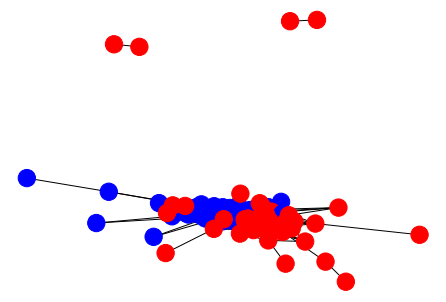

In [45]:
color_map_cluster = np.array([])
for node in G:
    if (predicted_label[node]==0):
        color_map_cluster = np.append(color_map_cluster, 'red')
    elif (predicted_label[node]==1):
        color_map_cluster = np.append(color_map_cluster, 'blue')
    else:
        color_map_cluster = np.append(color_map_cluster, 'yellow')
nx.draw(G, node_color=color_map_cluster)
plt.plot()